# 最近12個月内有使用G@C的人在未有G@C回收網絡前的回收習慣 與 demographics

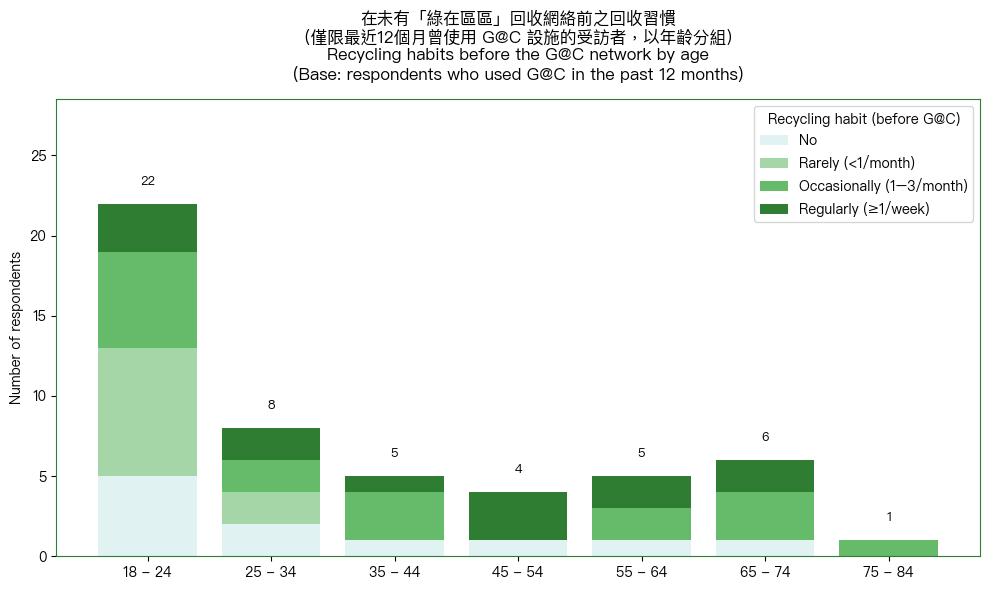

In [1]:
# ------------------------------------------------------------
# Stacked bar chart:
# "Recycling habits before the G@C network and demographics (Age)
#  of those who used G@C in the past 12 months"
#
# How to run:
#   - File path assumes this script / notebook lives next to folder
#       ../GCAP3226 G@C Survey Responses_cleaned data.xlsx
#   - Run; it will only show ONE stacked bar chart.
# ------------------------------------------------------------

# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- helper to find a column by header patterns ----------
def find_col(columns, patterns):
    """Return the first column whose header matches any regex in patterns."""
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    # explicit patterns first
    for c, norm in cols:
        for p in patterns:
            if re.search(p, norm, flags=re.IGNORECASE):
                return c
    return None

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- locate relevant columns ----------

# Recycling habit *before* G@C
habit_patterns = [
    r"before\s+the\s+green@community\s+recycling\s+network\s+was\s+introduced.*recycling\s+habit",
    r"在未有.*綠在區區.*回收網絡前.*回收習慣",
]
habit_col = find_col(df.columns, habit_patterns)
if habit_col is None:
    raise RuntimeError("Could not find 'recycling habit before G@C' column.")

# Age
age_patterns = [
    r"\bage\b",          # English
    r"年齡",             # Chinese
]
age_col = find_col(df.columns, age_patterns)
if age_col is None:
    raise RuntimeError("Could not find 'Age' column.")

# "In the past 12 months, have you used any Green@Community recycling facility?"
use_patterns = [
    r"in\s+the\s+past\s+12\s+months.*used\s+any\s+green@community\s+recycling\s+facility",
    r"在最近12個月.*有否使用過.*綠在區區.*回收設施",
]
use_col = find_col(df.columns, use_patterns)
if use_col is None:
    raise RuntimeError("Could not find the 'past 12 months use' Yes/No column.")

# ---------- extract series ----------
habit_raw = df[habit_col].astype(str)
age_raw   = df[age_col].astype(str)
use_raw   = df[use_col].astype(str)

# ---------- map Yes/No usage ----------
def used_facility(text):
    s = str(text).strip().lower()
    if s in {"yes", "y", "是", "有"}:
        return True
    if s in {"no", "n", "否", "沒有", "未有", "無"}:
        return False
    return None

use_flags = use_raw.map(used_facility)

# Only respondents who HAVE used G@C in the past 12 months
mask_used = (use_flags == True)

habit_used = habit_raw[mask_used]
age_used   = age_raw[mask_used]

# ---------- normalise recycling habit categories ----------
def normalise_habit(s: str) -> str:
    s = str(s).strip().lower()
    # order matters (regularly vs rarely, etc.)
    if "regularly" in s or "at least once per week" in s:
        return "Regularly (≥1/week)"
    if "occasionally" in s or "1–3 times per month" in s or "1-3 times per month" in s:
        return "Occasionally (1–3/month)"
    if "rarely" in s or "less than once per month" in s:
        return "Rarely (<1/month)"
    if s == "no" or "沒有" in s or "無" in s:
        return "No"
    # fallback: keep original text
    return s or "No"

habit_norm = habit_used.map(normalise_habit)

# ---------- normalise age categories ----------
def normalise_age(s: str) -> str:
    return str(s).strip()

age_norm = age_used.map(normalise_age)

# ---------- keep only rows with both habit & age ----------
mask_valid = (habit_norm != "") & (age_norm != "")
habit_norm = habit_norm[mask_valid]
age_norm   = age_norm[mask_valid]

# ---------- define category orders ----------
habit_order = [
    "No",
    "Rarely (<1/month)",
    "Occasionally (1–3/month)",
    "Regularly (≥1/week)",
]

age_order_all = [
    "17 or below",
    "18 - 24",
    "25 - 34",
    "35 - 44",
    "45 - 54",
    "55 - 64",
    "65 - 74",
    "75 - 84",
    "85 or above",
]
# keep only those actually present
age_present = [a for a in age_order_all if a in set(age_norm)]

# ---------- build cross-tab ----------
ct = pd.crosstab(age_norm, habit_norm)

# ensure order of rows/columns
ct = ct.reindex(index=age_present, columns=habit_order, fill_value=0)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- stacked bar chart ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

x = range(len(ct.index))
bottom = [0] * len(ct.index)

colors = {
    "No": "#e0f2f1",
    "Rarely (<1/month)": "#a5d6a7",
    "Occasionally (1–3/month)": "#66bb6a",
    "Regularly (≥1/week)": "#2e7d32",
}

# green border for the axes
for spine in ax.spines.values():
    spine.set_color("#2e7d32")

for habit in habit_order:
    values = ct[habit].values
    ax.bar(x, values, bottom=bottom, color=colors.get(habit, "#cccccc"),
           label=habit)
    bottom = [b + v for b, v in zip(bottom, values)]

# optional: total labels on top of each bar
totals = ct.sum(axis=1).values
max_total = totals.max() if len(totals) > 0 else 0
ax.set_ylim(0, max_total * 1.25 + 1)

for i, total in enumerate(totals):
    ax.text(i, total + max(1, max_total * 0.03),
            str(int(total)),
            ha="center", va="bottom", fontsize=9)

ax.set_xticks(list(x))
ax.set_xticklabels(ct.index, rotation=0, ha="center")
ax.set_ylabel("Number of respondents")

title_cn = "在未有「綠在區區」回收網絡前之回收習慣\n（僅限最近12個月曾使用 G@C 設施的受訪者，以年齡分組）"
title_en = "Recycling habits before the G@C network by age\n(Base: respondents who used G@C in the past 12 months)"
ax.set_title(title_cn + "\n" + title_en, pad=14)

ax.legend(title="Recycling habit (before G@C)", loc="upper right")

plt.tight_layout()
plt.show()
